# LSTM과 GRU 셀

## LSTM 신경망 훈련하기

In [1]:
import time

import numpy as np

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense    
from tensorflow.keras.layers import SimpleRNN    
from tensorflow.keras.layers import Embedding    
from tensorflow.keras.layers import LSTM  
from tensorflow.keras.layers import GRU    
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline  

from tensorflow.keras.datasets import imdb

# ---------------------------------------------------------------------
# gpu 사용시 런타임에서 필요한 양만큼의 GPU 메모리를 할당후 자동 증가 처리
# OS 메모리도 초기화됨.
# ---------------------------------------------------------------------
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
    
# ---------------------------------------------------------------------


In [2]:
(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [3]:
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)
test_seq = pad_sequences(test_input, maxlen=100)

In [4]:
model = Sequential()

# 500: 어휘 사전의 단어의 수, 16: 임베딩 벡터의 크기, 100: 1개의 문장이 100개의 단어로 구성됨(timestep 수 100)
model.add(Embedding(500, 16, input_length=100))
model.add(LSTM(8))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('imdb_lstm.h5')
early_stopping = EarlyStopping(patience=1, restore_best_weights=True)

start = time.time()
hist = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint, early_stopping])
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))
# cpu:  초, i5 8500:  초
# Colab cpu: 600 초, gpu: 90 초

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           8000      
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
313/313 [==============================] - 36s 10ms/step - loss: 0.6930 - accuracy: 0.5093 - val_loss: 0.6920 - val_accuracy: 0.5496
Epoch 2/100
313/313 [==============================] - 2s 8ms/step - loss: 0.6911 - accuracy: 0.5801 - val_loss: 0.6889 - val_accuracy: 0.6042
Epoch 3/100
313/313 [==============================] - 2s 8ms/step - loss: 0.6859 - accuracy: 0.

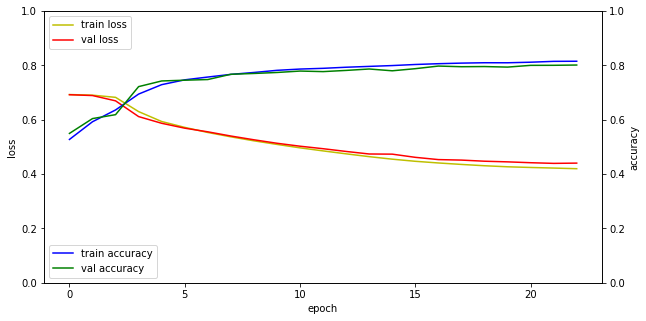

In [5]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [6]:
test_loss, test_acc = model.evaluate(test_seq, test_target, batch_size=64, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.4359149932861328 /정확도: 79.8479974269867 %


## 순환 층에 드롭아웃 적용하기

In [7]:
model = Sequential()

# 500: 어휘 사전의 단어의 수, 16: 임베딩 벡터의 크기, 100: 1개의 문장이 100개의 단어로 구성됨(timestep 수 100)
model.add(Embedding(500, 16, input_length=100))
model.add(LSTM(8, dropout=0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('imdb_lstm_dropout.h5')
early_stopping = EarlyStopping(patience=1, restore_best_weights=True)

start = time.time()
hist = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                 validation_data=(val_seq, val_target),
                 callbacks=[checkpoint, early_stopping])
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))
# cpu:  초, i5 8500:  초
# Colab cpu: 600 초, gpu: 51 초

Epoch 1/100
313/313 [==============================] - 5s 9ms/step - loss: 0.6928 - accuracy: 0.5196 - val_loss: 0.6917 - val_accuracy: 0.5706
Epoch 2/100
313/313 [==============================] - 2s 8ms/step - loss: 0.6914 - accuracy: 0.5650 - val_loss: 0.6895 - val_accuracy: 0.6124
Epoch 3/100
313/313 [==============================] - 2s 8ms/step - loss: 0.6885 - accuracy: 0.6043 - val_loss: 0.6844 - val_accuracy: 0.6472
Epoch 4/100
313/313 [==============================] - 2s 8ms/step - loss: 0.6818 - accuracy: 0.6348 - val_loss: 0.6675 - val_accuracy: 0.6842
Epoch 5/100
313/313 [==============================] - 2s 8ms/step - loss: 0.6527 - accuracy: 0.6878 - val_loss: 0.5870 - val_accuracy: 0.7088
Epoch 6/100
313/313 [==============================] - 2s 8ms/step - loss: 0.5757 - accuracy: 0.7138 - val_loss: 0.5556 - val_accuracy: 0.7358
Epoch 7/100
313/313 [==============================] - 2s 8ms/step - loss: 0.5479 - accuracy: 0.7370 - val_loss: 0.5315 - val_accuracy: 0.7548

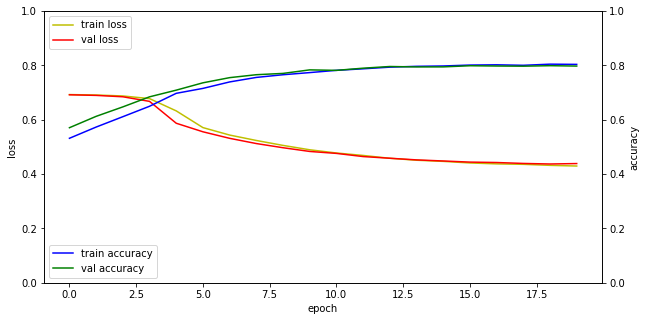

In [8]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [9]:
test_loss, test_acc = model.evaluate(test_seq, test_target, batch_size=64, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.43433457612991333 /정확도: 79.97599840164185 %


## 2개의 층을 연결하기

In [10]:
model = Sequential()

# 500: 어휘 사전의 단어의 수, 16: 임베딩 벡터의 크기, 100: 1개의 문장이 100개의 단어로 구성됨(timestep 수 100)
model.add(Embedding(500, 16, input_length=100))
 # return_sequences=True: LSTM을 2개 이상 구성하는 경우, 100개의 타임 스텝이 100개의 출력이 이루어짐.
model.add(LSTM(8, return_sequences=True))
model.add(LSTM(8)) # 8개만 출력함.
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint = ModelCheckpoint('imdb_lstm.h5')
early_stopping = EarlyStopping(patience=1, restore_best_weights=True)

start = time.time()
hist = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint, early_stopping])
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))
# cpu:  초, i5 8500:  초
# Colab cpu: 750 초, gpu: 63 초

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 16)           8000      
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 8)            800       
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
313/313 [==============================] - 7s 14ms/step - loss: 0.6929 - accuracy: 0.5246 - val_loss: 0.6920 - val_accuracy: 0.5796
Epoch 2/100
313/313 [==============================] - 4s 12ms/step - loss: 0.6913 - accuracy: 0.5972 - va

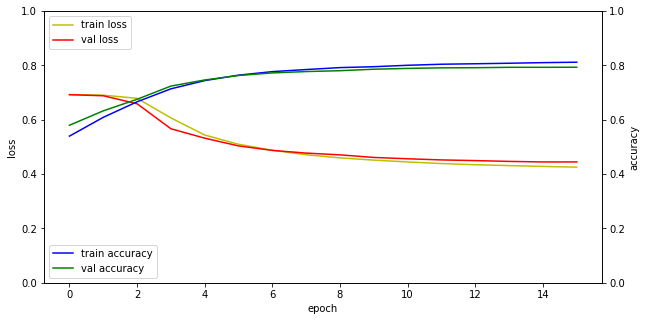

In [11]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [12]:
test_loss, test_acc = model.evaluate(test_seq, test_target, batch_size=64, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.44120317697525024 /정확도: 79.48799729347229 %


## GRU 신경망 훈련하기

In [13]:
model = Sequential()

model.add(Embedding(500, 16, input_length=100))
model.add(GRU(8))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint = ModelCheckpoint('imdb_gru.h5')
early_stopping = EarlyStopping(patience=1, restore_best_weights=True)

start = time.time()
hist = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint, early_stopping])
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))
# cpu:  초, i5 8500:  초
# Colab cpu: 257 초, gpu: 64 초

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 16)           8000      
_________________________________________________________________
gru (GRU)                    (None, 8)                 624       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
313/313 [==============================] - 5s 9ms/step - loss: 0.6925 - accuracy: 0.5205 - val_loss: 0.6913 - val_accuracy: 0.5368
Epoch 2/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6899 - accuracy: 0.5617 - val_loss: 0.6877 - val_accuracy: 0.5790
Epoch 3/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6855 - accuracy: 0.

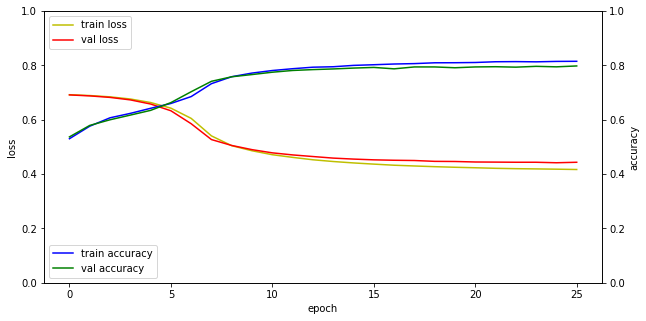

In [14]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [15]:
test_loss, test_acc = model.evaluate(test_seq, test_target, batch_size=64, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.4370167553424835 /정확도: 79.79599833488464 %
